In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input,GlobalMaxPool1D,Dropout
from keras.utils import plot_model

import nltk
import re
from nltk.corpus import stopwords #corpus is collection of text
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score

Using TensorFlow backend.


In [2]:
# Load train data
train = pd.read_csv('Data\\train.csv')
train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [3]:
#drop the Nan Values
train.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [4]:
# replace na
train['text'] = train['text'].replace(np.nan, train['title'])
train.isnull().sum()

id           0
title      558
author    1957
text         0
label        0
dtype: int64

In [5]:
#Get the Depndent feature
X_train=train.drop('label',axis=1)
y_train=train['label']

In [6]:
# set vocabulary size
vo_size=500
messages=X_train.copy()
messages.reset_index(inplace=True)

In [7]:
#dataset Preprocessing
ps =PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    print("Status: %s / %s" %(i, len(messages)), end="\r")
    review = re.sub('[^a-zA-Z]', ' ',messages['text'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [8]:
# one hot representation
onehot_rep = [one_hot(words, vo_size) for words in corpus]

In [9]:
# pad_sequences
sent_length = 1000
embedded_doc=pad_sequences(onehot_rep, padding='pre', maxlen=sent_length)
print(embedded_doc)

[[  0   0   0 ... 193 376 342]
 [  0   0   0 ...  32 213 382]
 [  0   0   0 ... 314 479 100]
 ...
 [  0   0   0 ...  43 386   5]
 [  0   0   0 ... 489  13 371]
 [  0   0   0 ... 379 218 209]]


In [10]:
# model 1 build 
embedding_vector_feature = 100
model=Sequential()
model.add(Embedding(vo_size,embedding_vector_feature,input_length=sent_length))
model.add(LSTM(200))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 100)         50000     
_________________________________________________________________
lstm (LSTM)                  (None, 200)               240800    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 291,001
Trainable params: 291,001
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
# Plot title model
plot_model(model, to_file='model_plot2.png', show_shapes=True, show_layer_names=True)

In [12]:
# check shape 
len(embedded_doc),y_train.shape

(20800, (20800,))

In [13]:
# final data for NN
X_final=np.array(embedded_doc)
y_final=np.array(y_train)
X_final.shape,y_final.shape

((20800, 1000), (20800,))

In [14]:
# train model 1
history = model.fit(X_final,y_final, validation_split=0.2, epochs=10, batch_size=256)

C:\Anaconda\envs\py35\lib\site-packages\tensorflow\python\ops\gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 16640 samples, validate on 4160 samples
Epoch 1/10
16640/16640 [==============================] - 156s 9ms/step - loss: 0.6650 - acc: 0.6164 - val_loss: 0.6051 - val_acc: 0.6844
Epoch 2/10
16640/16640 [==============================] - 132s 8ms/step - loss: 0.5204 - acc: 0.7493 - val_loss: 0.4020 - val_acc: 0.8173
Epoch 3/10
16640/16640 [==============================] - 132s 8ms/step - loss: 0.3662 - acc: 0.8377 - val_loss: 0.3613 - val_acc: 0.8389
Epoch 4/10
16640/16640 [==============================] - 133s 8ms/step - loss: 0.3071 - acc: 0.8683 - val_loss: 0.3363 - val_acc: 0.8637
Epoch 5/10
16640/16640 [==============================] - 131s 8ms/step - loss: 0.3114 - acc: 0.8643 - val_loss: 0.3361 - val_acc: 0.8570
Epoch 6/10
16640/16640 [==============================] - 131s 8ms/step - loss: 0.2975 - acc: 0.8718 - val_loss: 0.4936 - val_acc: 0.8000
Epoch 7/10
16640/16640 [==============================] - 132s 8ms/step - loss: 0.2819 - acc: 0.8811 - val_loss: 0.3180 - v

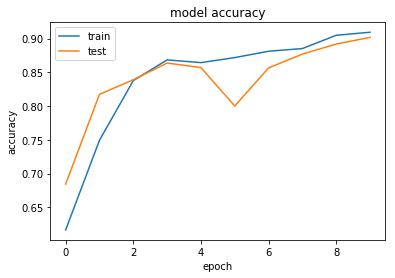

In [15]:
# summarize history for accuracy

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

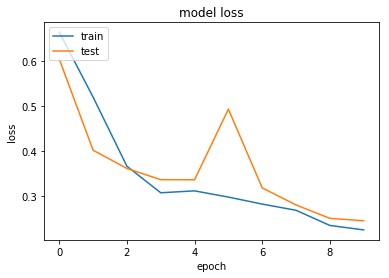

In [16]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
# model 2 build 
model = Sequential()
model.add(Embedding(vo_size,embedding_vector_feature,input_length=sent_length))
model.add(LSTM(100, return_sequences=True,name='lstm_layer'))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.1))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
# Plot title model
plot_model(model, to_file='model_plot3.png', show_shapes=True, show_layer_names=True)

In [19]:
# train model 2
history = model.fit(X_final,y_final, validation_split=0.2, epochs=10, batch_size=256)

C:\Anaconda\envs\py35\lib\site-packages\tensorflow\python\ops\gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 16640 samples, validate on 4160 samples
Epoch 1/10
16640/16640 [==============================] - 126s 8ms/step - loss: 0.6283 - acc: 0.6296 - val_loss: 0.5517 - val_acc: 0.7262
Epoch 2/10
16640/16640 [==============================] - 126s 8ms/step - loss: 0.5258 - acc: 0.7239 - val_loss: 0.4867 - val_acc: 0.7401
Epoch 3/10
16640/16640 [==============================] - 126s 8ms/step - loss: 0.4163 - acc: 0.8047 - val_loss: 0.3324 - val_acc: 0.8613
Epoch 4/10
16640/16640 [==============================] - 126s 8ms/step - loss: 0.3356 - acc: 0.8534 - val_loss: 0.2895 - val_acc: 0.8752
Epoch 5/10
16640/16640 [==============================] - 126s 8ms/step - loss: 0.2685 - acc: 0.8904 - val_loss: 0.2925 - val_acc: 0.8702
Epoch 6/10
16640/16640 [==============================] - 126s 8ms/step - loss: 0.2385 - acc: 0.9015 - val_loss: 0.2305 - val_acc: 0.9034
Epoch 7/10
16640/16640 [==============================] - 128s 8ms/step - loss: 0.2210 - acc: 0.9097 - val_loss: 0.2459 - v

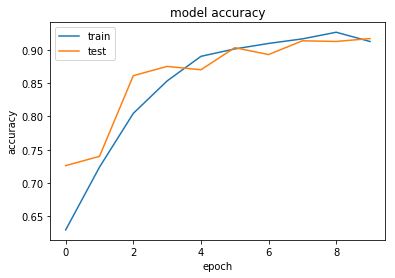

In [20]:
# summarize history for accuracy

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

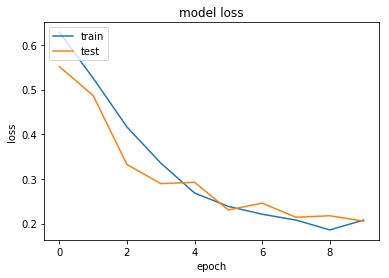

In [21]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
# load test
test = pd.read_csv('Data\\test.csv')
test.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [23]:
# check na in test
test.isnull().sum()

id          0
title     122
author    503
text        7
dtype: int64

In [24]:
# Replace na
test['text'] = test['text'].replace(np.nan, test['title'])
test.isnull().sum()

id          0
title     122
author    503
text        0
dtype: int64

In [25]:
# prepare test data for NN
X_test=test
messages=X_test.copy()
messages.reset_index(inplace=True)
ps =PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    print("Status: %s / %s" %(i, len(messages)), end="\r")
    review = re.sub('[^a-zA-Z]', ' ',messages['text'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)
onehot_rep = [one_hot(words, vo_size) for words in corpus]
embedded_doc=pad_sequences(onehot_rep, padding='pre', maxlen=sent_length)
X_test_final=np.array(embedded_doc)

In [26]:
# predict final
y_pred_final=model.predict_classes(X_test_final)
y_pred_final = pd.DataFrame(y_pred_final)
submit = pd.concat([test['id'].reset_index(drop=True), y_pred_final], axis=1)
submit.rename(columns={ submit.columns[1]: "label" }, inplace = True)
submit.to_csv('submit_2.csv', index=False)

In [27]:
# Save model
model.save_weights("model_text.h5")